In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cars = pd.read_csv("./concatenated_data.csv", index_col=0)
del cars["description"]
cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9437 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   marque        9411 non-null   object 
 1   modele        9411 non-null   object 
 2   prix          9432 non-null   float64
 3   kilometrage   9411 non-null   float64
 4   annee         9411 non-null   object 
 5   localisation  9421 non-null   object 
 6   date_ajout    3336 non-null   object 
 7   carrosserie   9191 non-null   object 
 8   energie       9411 non-null   object 
 9   puissance     9411 non-null   object 
 10  boite         9411 non-null   object 
 11  couleur       9400 non-null   object 
 12  prix_neuve    1955 non-null   float64
 13  cylindree     5855 non-null   object 
dtypes: float64(3), object(11)
memory usage: 1.1+ MB


In [3]:
# prix -> abs(prix)

cars["prix"] = abs(cars["prix"])


In [4]:
# If prix is 0 -> prix = nan
prix_is_0 = cars["prix"] == 0
cars.loc[prix_is_0, "prix"] = np.nan


In [5]:
# If prix less than 500 -> prix *= 1000

prix_less_than_1000 = cars["prix"] <= 500
cars.loc[prix_less_than_1000, "prix"] *= 1000


In [6]:
# If prix over 1_000_000 -> prix = nan

prix_over_1000000 = cars["prix"] >= 1e8
cars.loc[prix_over_1000000, "prix"] = np.nan


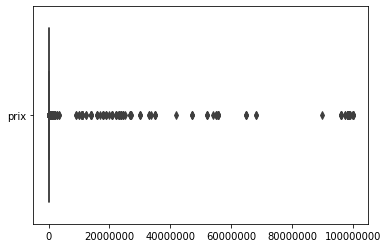

In [7]:
ax = sns.boxplot(data=cars[["prix"]], orient="h")
ax.ticklabel_format(style="plain", axis="x")
plt.show()


In [8]:
q1 = np.percentile(cars.loc[cars["prix"].notna(), "prix"], 25)
q3 = np.percentile(cars.loc[cars["prix"].notna(), "prix"], 75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(lower_bound)


-43250.0


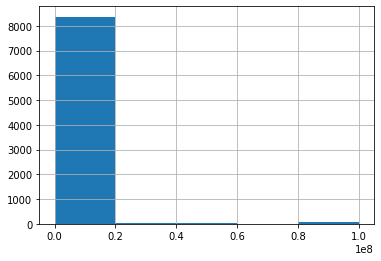

In [9]:
cars["prix"].hist(bins=5)
plt.show()


In [10]:
cars.loc[cars["prix"] > 400_000]


,marque,modele,prix,kilometrage,annee,localisation,date_ajout,carrosserie,energie,puissance,boite,couleur,prix_neuve,cylindree
122,jaguar,f pace,450000.0,28000.0,01-2018,Tunis,27.03.2023,4 x 4,Essence,24,Automatique,Blanc,390000.0,NaN
561,porsche,macan,465000.0,7500.0,05-2022,Sfax,26.03.2023,4 x 4,Essence,17,Automatique,Bleu,427500.0,NaN
575,mercedes benz,gle coupe,550000.0,50000.0,07-2021,Sfax,26.03.2023,4 x 4,Essence,12,Automatique,Blanc,540000.0,NaN
641,porsche,cayenne,480000.0,60000.0,01-2020,Ariana,25.03.2023,4 x 4,Essence,23,Automatique,Noir,570000.0,NaN
659,bmw,x5,485000.0,34000.0,01-2020,Tunis,25.03.2023,4 x 4,Essence,23,Automatique,Blanc,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5692,Citroen,Berlingo,17000000.0,300.0,2009,Mahdia,NaN,Autres,Diesel,7.0,Manuelle,Blanc,NaN,1.2L
5746,Opel,Corsa,11000000.0,378000.0,1996,Monastir,NaN,Autres,Essence,1.2,Manuelle,Vert,NaN,>4.0L
5783,Dacia,Logan MCV,98400717.0,130000.0,2016,Tunis,NaN,Monospace,Essence,5.0,Manuelle,Blanc,NaN,1.2L
5833,Ford,Focus C-MAX,19000000.0,200000.0,2007,Sfax,NaN,Berline,Essence,6.0,Manuelle,Noir,NaN,1.4L


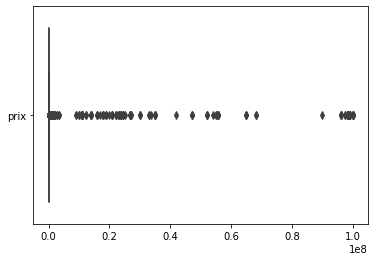

In [11]:
sns.boxplot(data=cars[["prix"]], orient="h")
plt.show()


In [12]:
# kilometrage -> abs(kilometrage)

cars["kilometrage"] = abs(cars["kilometrage"])


In [13]:
# If kilometrage < 10 -> kilometrage = nan

kilometrage_less_than_10 = cars["kilometrage"] < 10
cars.loc[kilometrage_less_than_10, "kilometrage"] = np.nan


In [14]:
# If kilometrage <= 1000 -> kilometrage *= 1000

kilometrage_less_than_1000 = cars["kilometrage"] <= 1000
cars.loc[kilometrage_less_than_1000, "kilometrage"] *= 1000


In [15]:
# If kilometrage >= 1 000 000 -> kilometrage = nan

kilometrage_over_1000000 = cars["kilometrage"] >= 1000000
cars.loc[kilometrage_over_1000000, "kilometrage"] = np.nan


In [16]:
# Applying str.title() to each column

for col in cars.columns:
    if cars[col].dtype == "object":
        cars[col] = cars[col].str.title()


In [17]:
# Exploring the values of "localisation" column

localisation_values = cars["localisation"].unique()
print(localisation_values, len(localisation_values))


['Ariana' 'Tunis' 'Ben Arous' 'Bizerte' 'Monastir' 'Béja' 'La Manouba'
 'Sousse' 'Nabeul' 'Sidi Bouzid' 'Gafsa' 'Kairouan' 'Sfax' 'Mahdia'
 'Tozeur' 'Médenine' 'Kasserine' 'Le Kef' 'Gabès' 'Zaghouan' 'Jendouba'
 'Kébili' 'Siliana' 'Manouba' 'Gabes' 'Tataouine' nan] 27


In [18]:
# Unify and fix the values of the "localisation" column

my_dict = {
    "Béja": "Beja",
    "La Manouba": "Manouba",
    "Gabès": "Gabes",
    "Médenine": "Medenine",
    "Kébili": "Kebili",
}
cars.replace({"localisation": my_dict}, inplace=True)


In [19]:
#specifying the field datatype
cars.couleur=cars.couleur.astype(str)
# Exploring the values of the "couleur" column
couleurs = cars["couleur"].unique()
print(couleurs, len(couleurs))
len(cars[cars["couleur"].isna()])


['Blanc' 'Rouge' 'Noir' 'Gris Shark' 'Beige' 'Bleu' 'Gris Argent'
 'Gris Anthracite' 'Autre' 'Orange' 'Marron' 'Vert' 'Jaune' 'Aubergine'
 'Bleu Roi' 'Gris' 'Bronze' 'Gris Métallisé' 'Gris Foncé' 'Gris Titanuim'
 'Bleu Gris' 'Noire' 'Miel' 'Blanc Cristal' 'nan' 'Bleu/Gris' 'Mauve Gris'
 'Gris Charbon' '*****' 'Blanche' 'Grise' 'Verte' 'Bleu Métallisée'
 'Grise Metalisee' 'Bleu Métallisé' 'Gris Magnetic' 'Gris Clair Métallisé'
 "Feuille D'Argent" 'Maran' 'Grise Métallisée' 'Rouge Bordeaux' 'Camel'
 'Grenadine' 'Titanium' 'Champagne' 'Multicolore' 'Argent' 'Doré' 'Violet'
 'Corail'] 50


0

In [20]:
from thefuzz import fuzz
from thefuzz import process

In [60]:
#get all the words that match "gris"
matches = process.extract("bleu", couleurs, limit=30, scorer=fuzz.token_sort_ratio)
#take a look at them to choose min_ratio
matches

[('Bleu', 100),
 ('Bleu Roi', 67),
 ('Bleu Gris', 62),
 ('Bleu/Gris', 62),
 ('Blanche', 55),
 ('Bleu Métallisé', 50),
 ('Bleu Métallisée', 47),
 ('Blanc', 44),
 ('Beige', 44),
 ('Bronze', 40),
 ('Violet', 40),
 ('Rouge Bordeaux', 33),
 ('Aubergine', 31),
 ('Multicolore', 27),
 ('Vert', 25),
 ('Miel', 25),
 ('Blanc Cristal', 24),
 ('Rouge', 22),
 ('Autre', 22),
 ('Jaune', 22),
 ('Noire', 22),
 ('Grise', 22),
 ('Verte', 22),
 ('Grise Métallisée', 22),
 ('Camel', 22),
 ('Grise Metalisee', 21),
 ('Orange', 20),
 ("Feuille D'Argent", 20),
 ('Argent', 20),
 ('Corail', 20)]

In [76]:
couleurs_gris = ["grisa" if c.lower().startswith("gris") else c for c in couleurs]

couleurs_gris=[c[:-4] if c.lower().endswith("gris")  else c for c in couleurs_gris]
couleurs_gris
matches = process.extract("Gris a", couleurs, limit=30, scorer=fuzz.token_sort_ratio)
score = fuzz.token_sort_ratio("gris ", "Gris Anthracite")
print(score)
matches

42


[('Gris', 80),
 ('Grise', 73),
 ('Gris Argent', 71),
 ('Gris Foncé', 67),
 ('Bleu Gris', 67),
 ('Bleu/Gris', 67),
 ('Gris Charbon', 67),
 ('Gris Anthracite', 57),
 ('Blanc Cristal', 53),
 ('Gris Shark', 50),
 ('Mauve Gris', 50),
 ('Gris Clair Métallisé', 50),
 ('Gris Métallisé', 44),
 ('Bleu Roi', 43),
 ('Gris Titanuim', 42),
 ('Gris Magnetic', 42),
 ('Aubergine', 40),
 ('Grise Métallisée', 40),
 ('Grenadine', 40),
 ('Grise Metalisee', 38),
 ('Autre', 36),
 ('Maran', 36),
 ('Orange', 33),
 ('Marron', 33),
 ('Bleu Métallisé', 33),
 ('Argent', 33),
 ('Corail', 33),
 ('Bleu Métallisée', 32),
 ('Rouge Bordeaux', 30),
 ('Titanium', 29)]

In [69]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("All done!")
    print(strings, len(strings))

In [71]:
replace_matches_in_column(cars,"couleur","gris",70)

All done!
['Blanc' 'Rouge' 'Noir' 'gris' 'Beige' 'Bleu' 'Gris Anthracite' 'Autre'
 'Orange' 'Marron' 'Vert' 'Jaune' 'Violet' 'Bronze' 'Argent' 'nan' nan
 'Verte' 'Bleu Métallisé' 'Camel' 'Multicolore' 'Doré'] 22


In [73]:
cars["couleur"].unique()

array(['Blanc', 'Rouge', 'Noir', 'gris', 'Beige', 'Bleu',
       'Gris Anthracite', 'Autre', 'Orange', 'Marron', 'Vert', 'Jaune',
       'Violet', 'Bronze', 'Argent', 'nan', nan, 'Verte',
       'Bleu Métallisé', 'Camel', 'Multicolore', 'Doré'], dtype=object)

In [27]:
# Unify and fix the values of the "couleur" column

my_dict = {
    "Blanche": "Blanc",
    "Blanc Cristal": "Blanc",
    "Grise": "Gris",
    "Gris Métallisé": "Gris",
    "Grise Metalisee": "Gris",
    "Grise Métallisée": "Gris",
    "Gris Clair Métallisé": "Gris",
    "Gris Foncé": "Gris",
    "Gris Charbon": "Gris",
    "Gris Magnetic": "Gris",
    "Bleu Gris": "Bleu",
    "Bleu/Gris": "Bleu",
    "Bleu Roi": "Bleu",
    "Bleu Métallisée": "Bleu",
    "Gris Titanium": "Argent",
    "Gris Titanuim": "Argent",
    "Gris Argent": "Argent",
    "Feuille D'Argent": "Argent",
    "Titanium": "Argent",
    "Miel": "Jaune",
    "Champagne": "Jaune",
    "Grenadine": "Rouge",
    "Rouge Bordeaux": "Rouge",
    "Mauve Gris": "Violet",
    "Aubergine": "Violet",
    "Noire": "Noir",
    "Maran": "Marron",
    "Corail": "Orange",
}
cars.replace({"couleur": my_dict}, inplace=True)


In [28]:
# If couleur is "*****" -> couleur = nan

specified_couleur = cars["couleur"] == "*****"
cars[specified_couleur] = np.nan

In [29]:
# Remove month from year in the "annee" column and convert it to float

contains_hyphen = cars["annee"].str.contains("-") & cars["annee"].notna()
cars.loc[contains_hyphen, "annee"] = cars.loc[contains_hyphen, "annee"].apply(
    lambda string: string.split("-")[1]
)
contains_point = cars["annee"].str.contains("[.]") & cars["annee"].notna()
cars.loc[contains_point, "annee"] = cars.loc[contains_point, "annee"].apply(
    lambda string: string.split(".")[-1]
)
cars["annee"] = cars["annee"].astype(np.float64)

In [30]:
# If 10<= annee <= 23 -> annee += 2000, if 60 <= annee -> annee += 1900, else annee = nan

annee_between_0_and_23 = (cars["annee"] >= 10) & (cars["annee"] <= 23)
cars.loc[annee_between_0_and_23, "annee"] += 2000
annee_more_than_60 = (cars["annee"] >= 60) & (cars["annee"] <= 99)
cars.loc[annee_more_than_60, "annee"] += 1900
correct_annee = (cars["annee"] >= 1960) & (cars["annee"] <= 2023)
cars.loc[~correct_annee, "annee"] = np.nan


In [31]:
# Convert N.D to nan in the "puissance" column

puissance_is_ND = cars["puissance"] == "N.D"
cars.loc[puissance_is_ND, "puissance"] = np.nan

In [32]:
# Convert the column "puissance" to float

contains_CV = cars["puissance"].str.contains("C") & cars["puissance"].notna()
cars.loc[contains_CV, "puissance"] = cars.loc[contains_CV, "puissance"].apply(
    lambda string: string.split()[0]
)
cars["puissance"] = cars["puissance"].astype(np.float64)


In [33]:
# If puissance > 200 -> puissance = nan

puissance_over_200 = cars["puissance"] > 200
cars.loc[puissance_over_200, "puissance"] = np.nan


In [34]:
# Convert the column "cylindree" to float

contains_symbol = cars["cylindree"].str.contains("[><]") & cars["cylindree"].notna()
cars.loc[contains_symbol, "cylindree"] = cars.loc[contains_symbol, "cylindree"].apply(
    lambda string: string[1:]
)
cars.loc[cars["cylindree"].notna(), "cylindree"] = cars.loc[
    cars["cylindree"].notna(), "cylindree"
].apply(lambda string: string[:-1])
cars["cylindree"] = cars["cylindree"].astype(np.float64)


In [35]:
# Turn "date_ajout" column to datetime

cars["date_ajout"] = pd.to_datetime(cars["date_ajout"])

c:\Users\salma\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27.03.2023' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\salma\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '26.03.2023' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\salma\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '25.03.2023' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\salma\AppData\Local\Programs\Python\Python310\lib\site-packag

In [36]:
# Dropping duplicates

cars.drop_duplicates(inplace=True)


In [37]:
cars.to_csv("./new_clean_data.csv")
cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6059 entries, 0 to 5880
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   marque        6050 non-null   object        
 1   modele        6050 non-null   object        
 2   prix          5663 non-null   float64       
 3   kilometrage   5806 non-null   float64       
 4   annee         5994 non-null   float64       
 5   localisation  6046 non-null   object        
 6   date_ajout    3316 non-null   datetime64[ns]
 7   carrosserie   5832 non-null   object        
 8   energie       6050 non-null   object        
 9   puissance     6002 non-null   float64       
 10  boite         6050 non-null   object        
 11  couleur       6058 non-null   object        
 12  prix_neuve    1938 non-null   float64       
 13  cylindree     2516 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(7)
memory usage: 710.0+ KB
